In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
# Define paths
data_dir = '/kaggle/input/bcn20000'

# Training data directory and csv path
train_img_dir = os.path.join(data_dir, 'BCN_20k_train/bcn_20k_train')
train_metadata_path = os.path.join(data_dir, 'bcn_20k_train.csv')

# Testing data directory and csv path
test_img_dir = os.path.join(data_dir, 'BCN_20k_test/bcn_20k_test')
test_metadata_path = os.path.join(data_dir, 'bcn_20k_test.csv')



# Load metadata
metadata = pd.read_csv(train_metadata_path)
print(f"Total training images: {len(metadata)}")
print(f"Total testing images: {len(pd.read_csv(test_metadata_path))}")
metadata.head()

Total training images: 12413
Total testing images: 6533


,bcn_filename,age_approx,anatom_site_general,diagnosis,lesion_id,capture_date,sex,split
0,BCN_0000000001.jpg,55.0,anterior torso,MEL,BCN_0003884,2012-05-16,male,train
1,BCN_0000000003.jpg,50.0,anterior torso,MEL,BCN_0000019,2015-07-09,female,train
2,BCN_0000000004.jpg,85.0,head/neck,SCC,BCN_0003499,2015-11-23,male,train
3,BCN_0000000006.jpg,60.0,anterior torso,NV,BCN_0003316,2015-06-16,male,train
4,BCN_0000000010.jpg,30.0,anterior torso,BCC,BCN_0004874,2014-02-18,female,train


In [4]:
import plotly.express as px

fig = px.histogram(metadata, x='diagnosis', color='diagnosis',
                   title='Class Distribution',
                   category_orders={'diagnosis': sorted(metadata['diagnosis'].unique())})
fig.update_layout(xaxis_title='Diagnosis',
                  yaxis_title='Count',
                  bargap=0.2)
fig.update_xaxes(tickangle=45)
fig.show()


In [68]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [69]:
CLASS_MAP = {
    'NV': 0,
    'MEL': 1,
    'BCC': 2,
    'BKL': 3,
    'AK': 4,
    'SCC': 5,
    'DF': 6,
    'VASC': 7
}

In [70]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['bcn_filename']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label = CLASS_MAP[self.df.iloc[idx]['diagnosis']]  # consistent mapping
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [71]:
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['diagnosis'], random_state=42)

# Datasets
train_dataset = SkinLesionDataset(train_df, train_img_dir, transform=train_transforms)
val_dataset = SkinLesionDataset(val_df, train_img_dir, transform=val_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [75]:
from torchvision.models import resnet50

In [76]:
NUM_CLASSES = len(CLASS_MAP)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet50(pretrained=True)

# Replace classifier head
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [78]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    
        # Saving the model checkpoint for current epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss  
        }, f'/kaggle/working/resnet50_checkpoint_epoch{epoch}.pth')
    
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
        val_acc = correct / total
        val_accuracies.append(val_acc)
        print(f'Validation Accuracy: {val_acc:.4f}')
    
    # Print mean validation accuracy
    mean_val_acc = sum(val_accuracies) / len(val_accuracies)
    print(f'\n📊 Mean Validation Accuracy over {epochs} epochs: {mean_val_acc:.4f}')

In [79]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25)

Epoch 1/25, Loss: 1.0975
Validation Accuracy: 0.6416
Epoch 2/25, Loss: 0.8964
Validation Accuracy: 0.6621
Epoch 3/25, Loss: 0.7801
Validation Accuracy: 0.7189
Epoch 4/25, Loss: 0.6849
Validation Accuracy: 0.7374
Epoch 5/25, Loss: 0.6220
Validation Accuracy: 0.7483
Epoch 6/25, Loss: 0.5424
Validation Accuracy: 0.7749
Epoch 7/25, Loss: 0.4891
Validation Accuracy: 0.7596
Epoch 8/25, Loss: 0.4314
Validation Accuracy: 0.7813
Epoch 9/25, Loss: 0.4028
Validation Accuracy: 0.7773
Epoch 10/25, Loss: 0.3355
Validation Accuracy: 0.7878
Epoch 11/25, Loss: 0.3261
Validation Accuracy: 0.7974
Epoch 12/25, Loss: 0.2895
Validation Accuracy: 0.7789
Epoch 13/25, Loss: 0.2807
Validation Accuracy: 0.7998
Epoch 14/25, Loss: 0.2459
Validation Accuracy: 0.8159
Epoch 15/25, Loss: 0.2283
Validation Accuracy: 0.8083
Epoch 16/25, Loss: 0.2178
Validation Accuracy: 0.8272
Epoch 17/25, Loss: 0.1826
Validation Accuracy: 0.8023
Epoch 18/25, Loss: 0.1873
Validation Accuracy: 0.8168
Epoch 19/25, Loss: 0.1846
Validation 

In [81]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = list(CLASS_MAP.keys())
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

          NV       0.85      0.90      0.87       841
         MEL       0.85      0.80      0.82       572
         BCC       0.82      0.91      0.86       562
         BKL       0.77      0.68      0.72       228
          AK       0.75      0.64      0.69       147
         SCC       0.75      0.67      0.71        86
          DF       0.87      0.52      0.65        25
        VASC       0.89      0.77      0.83        22

    accuracy                           0.83      2483
   macro avg       0.82      0.74      0.77      2483
weighted avg       0.83      0.83      0.83      2483



In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# plot_confusion_matrix(y_true, y_pred, class_names)

In [86]:
from sklearn.metrics import confusion_matrix

def compute_sens_spec(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    sensitivity = []
    specificity = []

    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)

    for i in range(len(cm)):
        label = class_names[i] if class_names else f"Class {i}"
        print(f"{label}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

# Example usage:
# compute_sens_spec(y_true, y_pred, class_names)

In [87]:
class_names = list(CLASS_MAP.keys())

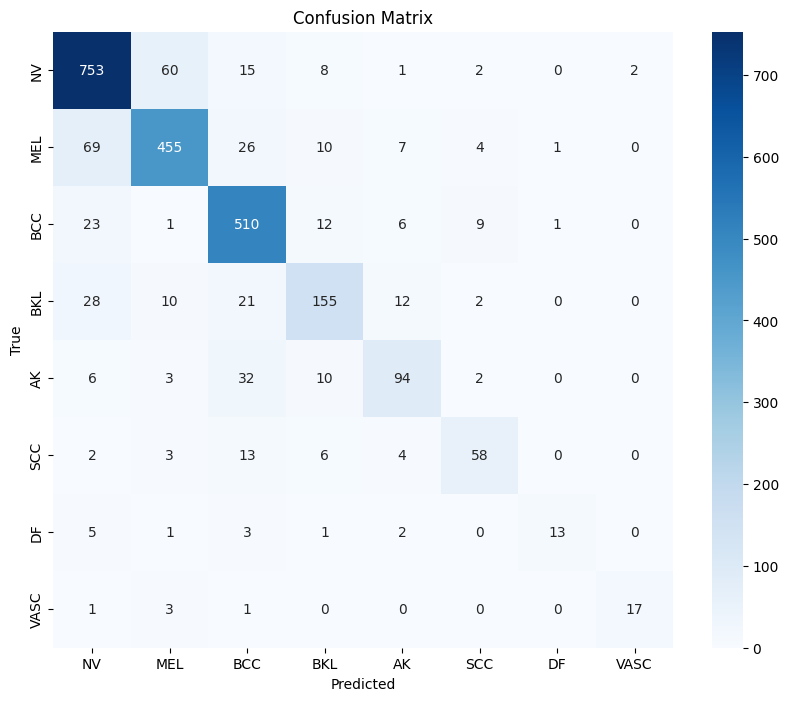

Confusion Matrix:
 [[753  60  15   8   1   2   0   2]
 [ 69 455  26  10   7   4   1   0]
 [ 23   1 510  12   6   9   1   0]
 [ 28  10  21 155  12   2   0   0]
 [  6   3  32  10  94   2   0   0]
 [  2   3  13   6   4  58   0   0]
 [  5   1   3   1   2   0  13   0]
 [  1   3   1   0   0   0   0  17]]
NV: Sensitivity = 0.8954, Specificity = 0.9184
MEL: Sensitivity = 0.7955, Specificity = 0.9576
BCC: Sensitivity = 0.9075, Specificity = 0.9422
BKL: Sensitivity = 0.6798, Specificity = 0.9792
AK: Sensitivity = 0.6395, Specificity = 0.9863
SCC: Sensitivity = 0.6744, Specificity = 0.9921
DF: Sensitivity = 0.5200, Specificity = 0.9992
VASC: Sensitivity = 0.7727, Specificity = 0.9992


In [90]:
# Confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names=class_names)

# Sensitivity & Specificity
compute_sens_spec(all_labels, all_preds, class_names=class_names)

In [93]:

import matplotlib.pyplot as plt

# Assuming you collected accuracy history in these lists during training:
# train_accuracies = [...]
# val_accuracies = [...]

def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

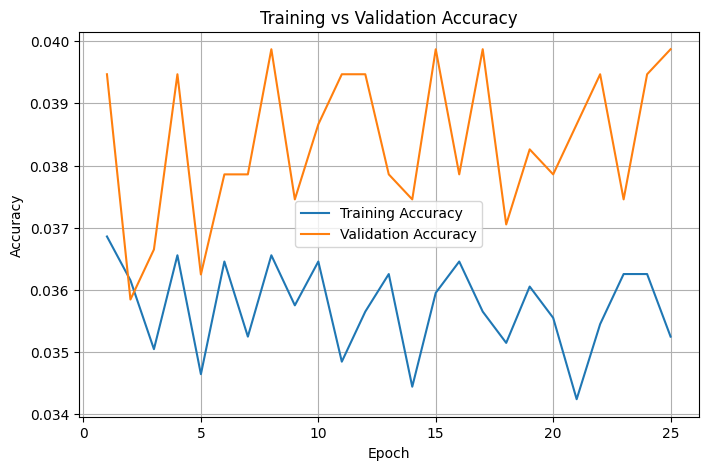

In [94]:
plot_accuracy(train_accuracies, val_accuracies)


### Model without data augmentation

In [95]:
# Define transformations
# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [96]:
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['diagnosis'], random_state=42)

# Datasets
train_dataset = SkinLesionDataset(train_df, train_img_dir, transform=val_transforms)
val_dataset = SkinLesionDataset(val_df, train_img_dir, transform=val_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [97]:
model_2 = resnet50(pretrained=True)
model_2.fc = nn.Linear(model_2.fc.in_features, NUM_CLASSES)
model_2 = model_2.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [99]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_accuracies = []
    val_accuracies = []
    train_losses = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}')

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }, f'/kaggle/working/resnet50_checkpoint_epoch{epoch}.pth')

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total if val_total > 0 else 0
        val_accuracies.append(val_acc)
        print(f'Validation Accuracy: {val_acc:.4f}')

    # Final mean summary
    print(f'\n📊 Mean Training Accuracy: {sum(train_accuracies)/len(train_accuracies):.4f}')
    print(f'📊 Mean Validation Accuracy: {sum(val_accuracies)/len(val_accuracies):.4f}')
    print(f'📉 Mean Training Loss: {sum(train_losses)/len(train_losses):.4f}')

    return train_losses, train_accuracies, val_accuracies

In [100]:
train_losses, train_accuracies, val_accuracies = train_model(model_2, train_loader, val_loader, criterion, optimizer, epochs=25)

Epoch 1/25, Loss: 2.0696, Train Accuracy: 0.2040
Validation Accuracy: 0.2143
Epoch 2/25, Loss: 2.0688, Train Accuracy: 0.2004
Validation Accuracy: 0.2090
Epoch 3/25, Loss: 2.0693, Train Accuracy: 0.2058
Validation Accuracy: 0.2227
Epoch 4/25, Loss: 2.0696, Train Accuracy: 0.2024
Validation Accuracy: 0.2155
Epoch 5/25, Loss: 2.0688, Train Accuracy: 0.2036
Validation Accuracy: 0.2243
Epoch 6/25, Loss: 2.0684, Train Accuracy: 0.2020
Validation Accuracy: 0.2151
Epoch 7/25, Loss: 2.0686, Train Accuracy: 0.2026
Validation Accuracy: 0.2195
Epoch 8/25, Loss: 2.0690, Train Accuracy: 0.2022
Validation Accuracy: 0.2211
Epoch 9/25, Loss: 2.0690, Train Accuracy: 0.2018
Validation Accuracy: 0.2247
Epoch 10/25, Loss: 2.0691, Train Accuracy: 0.2031
Validation Accuracy: 0.2139
Epoch 11/25, Loss: 2.0684, Train Accuracy: 0.2025
Validation Accuracy: 0.2280
Epoch 12/25, Loss: 2.0692, Train Accuracy: 0.2038
Validation Accuracy: 0.2179
Epoch 13/25, Loss: 2.0682, Train Accuracy: 0.2079
Validation Accuracy: 0.

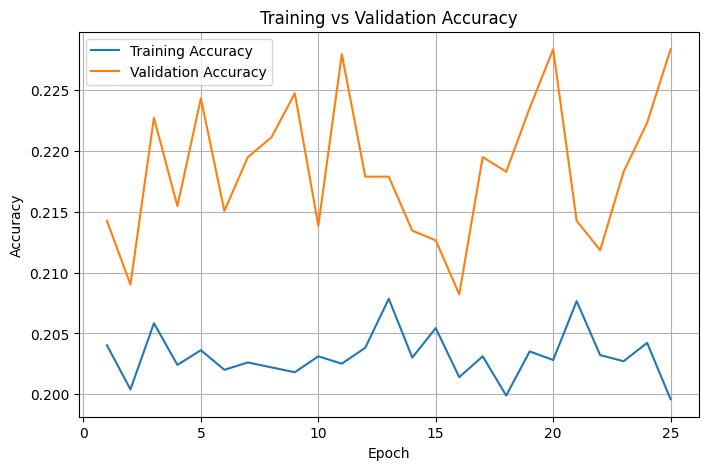

In [101]:
plot_accuracy(train_accuracies, val_accuracies)

In [103]:
model_2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model_2(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = list(CLASS_MAP.keys())
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

          NV       0.53      0.46      0.49       841
         MEL       0.00      0.00      0.00       572
         BCC       0.00      0.00      0.00       562
         BKL       0.11      0.77      0.19       228
          AK       0.00      0.00      0.00       147
         SCC       0.06      0.07      0.07        86
          DF       0.00      0.00      0.00        25
        VASC       0.00      0.00      0.00        22

    accuracy                           0.23      2483
   macro avg       0.09      0.16      0.09      2483
weighted avg       0.19      0.23      0.19      2483



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
class_names = list(CLASS_MAP.keys())

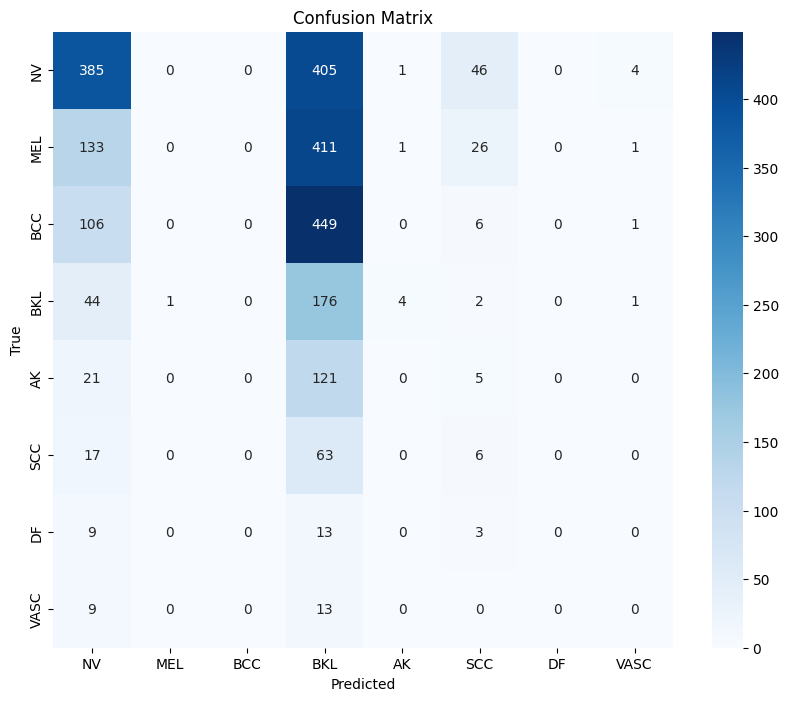

Confusion Matrix:
 [[385   0   0 405   1  46   0   4]
 [133   0   0 411   1  26   0   1]
 [106   0   0 449   0   6   0   1]
 [ 44   1   0 176   4   2   0   1]
 [ 21   0   0 121   0   5   0   0]
 [ 17   0   0  63   0   6   0   0]
 [  9   0   0  13   0   3   0   0]
 [  9   0   0  13   0   0   0   0]]
NV: Sensitivity = 0.4578, Specificity = 0.7935
MEL: Sensitivity = 0.0000, Specificity = 0.9995
BCC: Sensitivity = 0.0000, Specificity = 1.0000
BKL: Sensitivity = 0.7719, Specificity = 0.3459
AK: Sensitivity = 0.0000, Specificity = 0.9974
SCC: Sensitivity = 0.0698, Specificity = 0.9633
DF: Sensitivity = 0.0000, Specificity = 1.0000
VASC: Sensitivity = 0.0000, Specificity = 0.9972


In [106]:
# Confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names=class_names)

# Sensitivity & Specificity
compute_sens_spec(all_labels, all_preds, class_names=class_names)

In [107]:
import matplotlib.pyplot as plt

def plot_loss(train_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

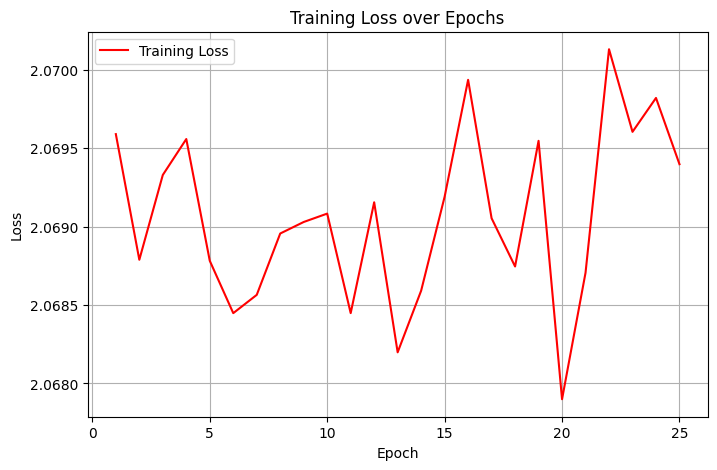

In [108]:
plot_loss(train_losses)

Tried to overfit the model to ensure everything is working correctly.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        epoch_loss = running_loss / total
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {train_acc:.4f}")


In [ ]:
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

small_df = train_df.sample(100, random_state=42)
small_dataset = SkinLesionDataset(small_df, train_img_dir, transform=val_transforms)
small_loader = DataLoader(small_dataset, batch_size=10, shuffle=True)

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_model(model, small_loader, small_loader, criterion, optimizer, epochs=5)
